In [1]:
#Import des biblothèques utiles

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse
import scipy.linalg as la
from time import process_time
from Parameters import *
from Hydrogen import *
from Field import *
from matplotlib.animation import FuncAnimation
import matplotlib.cm as cm
from Solve import *
import os




  0%|          | 0/200000 [00:00<?, ?it/s]

100%|██████████| 200000/200000 [00:58<00:00, 3437.33it/s]


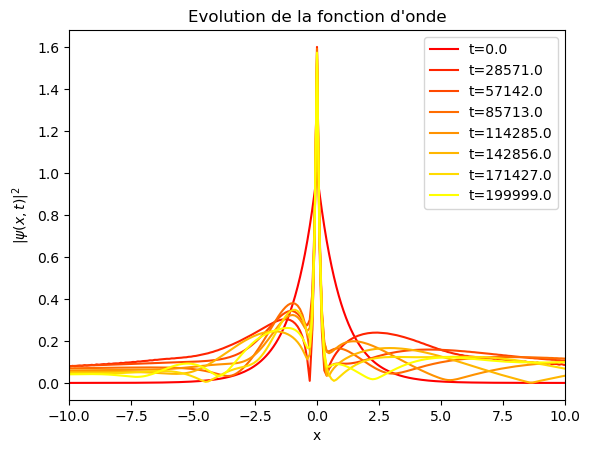

In [2]:
## Test: utilisation du solveur du fichier Solve.py et affichage de l'évolution de la fonction d'onde pour 8 valeurs sur l'intervalle de temps

# Rentrer les données de grille
x_min, nx, t_min, nt = -200, 4096, -10, 200000
wavefunction, x, t, A = psi([x_min, nx, t_min, nt], test=True)

# Definition de la coupure pour test hors boucle

def coupure(u):
    return np.exp(-(u/(2*200))**4)

T = np.linspace(0, nt-1, 8)
colors = cm.autumn(np.linspace(0, 1, len(T)))
for t, color in zip(T, colors):
    plt.plot(x, abs(wavefunction[int(t)]), label=f't={int(t):.1f}', color=color)
plt.xlim(-10, 10)
plt.legend()
plt.title("Evolution de la fonction d'onde")
plt.xlabel('x')
plt.ylabel('$|\psi(x,t)|^2$')
plt.show()


In [4]:
class CrankNicolson:

    
    def set_grid(self, x_min, x_max, n_x, t_min, t_max, n_t):

        self.x_min, self.x_max, self.n_x = x_min, x_max, n_x
        self.t_min, self.t_max, self.n_t = t_min, t_max, n_t
        self.x_pts, self.delta_x = np.linspace(x_min, x_max, n_x, retstep=True, endpoint=False)
        self.t_pts, self.delta_t = np.linspace(t_min, t_max, n_t, retstep=True, endpoint=False)
        
    def set_parameters(self, f):
        self.f = f

    def out_signal_calculation(self, t, psi):
        dV_dx = np.gradient(self.f(1, t), self.x_pts)
        a = np.trapz(-psi * dV_dx[np.newaxis,:] * np.conj(psi), self.x_pts)
        a = np.real(a)
        return a

    def wavelet_trasform(self, t, psi):
        X = self.scales[np.newaxis,:] * (t - self.t_pts[:,np.newaxis])
        wavelet = np.sqrt(self.scales[np.newaxis,:] / self.tau) * np.exp(-X**2 / (2 * self.tau**2) + 1j * X)
        delta_A = self.out_signal_calculation(t, psi)[:,np.newaxis] * wavelet * self.delta_t
        return delta_A

    # @staticmethod
    # @jax.jit
    # def wavelet_trasform(t, psi, f, t_pts, x_pts):

    #     FW = 0.057
    #     max_harm_order = 100
    #     tau = 620.4
    #     scales = FW * np.arange(1, max_harm_order)
    #     scales = jnp.asarray(scales)
    #     t_pts = jnp.asarray(t_pts)
    #     t = jnp.asarray(t)
    #     psi = jnp.asarray(psi)

    #     @jax.jit
    #     def out_signal_calculation(t, psi, f, x_pts):
    #         # Compute the gradient of f(1, t) with respect to x_pts
    #         dV_dx = jax.grad(lambda x: f(1, x))(t)  # Using JAX's auto-diff

    #         # Compute the integrand: -psi * dV_dx * conj(psi)
    #         integrand = -psi * dV_dx * jnp.conj(psi)

    #         # Trapezoidal integration over self.x_pts
    #         dx = x_pts[1] - x_pts[0]  # Assuming uniform spacing
    #         integral = jnp.sum(integrand, axis=-1) * dx

    #         # Return the real part of the integral
    #         return jnp.real(integral)

    #     @jax.jit
    #     # Define the wavelet function for one combination of t_pts and scales
    #     def wavelet_element(t_pt, scale):
    #         X = scale * (t - t_pt)
    #         return jnp.sqrt(scale / tau) * jnp.exp(-X**2 / (2 * tau**2) + 1j * X) * out_signal_calculation(t, psi, f, x_pts)

    #     # Vectorize across t_pts and scales
    #     wavelet_vectorized = jax.vmap(jax.vmap(wavelet_element, in_axes=(None, 0)), in_axes=(0, None))
    #     return np.array(wavelet_vectorized(t_pts, scales))


    def solve(self, psi_init, test=True, sparse=True, boundary_conditions=('dirichlet','dirichlet')):
            
        sig = (1j * self.delta_t) / (4 * self.delta_x**2)
        
        
        # Figure the data type
        data_type = type(sig*psi_init[0])
        
        self.psi_matrix = np.zeros([self.n_t, self.n_x], dtype=data_type)

        # Init fot A

        self.FW = 0.057
        self.max_harm_order = 100
        self.tau = 620.4
        self.scales = self.FW * np.arange(1, self.max_harm_order, 2)
        self.A = np.zeros([self.n_t, len(self.scales)], dtype=data_type)

        # Using sparse matrices and specialized tridiagonal solver speeds up the calculations
        if sparse:
            
            A = self._fillA_sp(sig, self.n_x, data_type)
            B = self._fillB_sp(sig, self.n_x, data_type)
            # Set boundary conditions
            for b in [0,1]:
                if boundary_conditions[b] == 'dirichlet':
                    # u(x,t) = 0
                    A[1,-b] = 1.0
                    A[2*b,1-3*b] = 0.0
                    B[-b,-b] = 0.0
                    B[-b,1-3*b] = 0.0
                elif boundary_conditions[b] == 'neumann':
                    # u'(x,t) = 0
                    A[2*b,1-3*b] = -2*sig
                    B[-b,1-3*b] = 2*sig
                    
            # Propagate
            psi = psi_init
            for n in tqdm(range(self.n_t)):
                t = self.t_min + n*self.delta_t
                self.psi_matrix[n,:] = psi
                self.psi_matrix[n,:]*= np.exp(-(self.x_pts/(2*200))**4)
                fpsi = self.f(psi,t)
                if n==0: fpsi_old = fpsi
                psi = la.solve_banded((1,1),A, B.dot(psi) - 1j*self.delta_t * (1.5 * fpsi - 0.5 * fpsi_old),\
                                    check_finite=False)
                fpsi_old = fpsi

                # Calculate A
                if not test:
                    self.A += self.wavelet_trasform(t, psi)
                #CrankNicolson.wavelet_trasform(t, psi, self.f, self.t_pts, self.x_pts)
                

        else:
            
            A = self._make_tridiag(sig, self.n_x, data_type)
            B = self._make_tridiag(-sig, self.n_x, data_type)

            # Set boundary conditions
            for b in [0,1]:
                if boundary_conditions[b] == 'dirichlet':
                    # u(x,t) = 0
                    A[-b,-b] = 1.0
                    A[-b,1-3*b] = 0.0
                    B[-b,-b] = 0.0
                    B[-b,1-3*b] = 0.0
                
                elif boundary_conditions[b] == 'neumann':
                    # u'(x,t) = 0
                    A[-b,1-3*b] = -2*sig
                    B[-b,1-3*b] = 2*sig

            # Propagate
            psi = psi_init
            for n in range(self.n_t):
                self.psi_matrix[n,:] = psi
                self.psi_matrix[n,:]*= np.exp(-(self.x_pts/(2*200))**4)
                fpsi = self.f(psi,t)
                if n==0: fpsi_old = fpsi
                psi = la.solve(A, B.dot(psi) - 1j*self.delta_t * (1.5 * fpsi - 0.5 * fpsi_old))
                fpsi_old = fpsi

                # Calculate A
                if not test:
                    self.A += self.wavelet_trasform(t, psi)
                #CrankNicolson.wavelet_trasform(t, psi, self.f, self.t_pts, self.x_pts)
                

    def get_final_psi(self):
        
        return self.psi_matrix[-1,:].copy()
        
    def _make_tridiag(self, sig, n, data_type):
    
        M = np.diagflat(np.full(n, (1+2*sig), dtype=data_type)) + \
            np.diagflat(np.full(n-1, -(sig), dtype=data_type), 1) + \
            np.diagflat(np.full(n-1, -(sig), dtype=data_type), -1)

        return M
    
    def _fillA_sp(self, sig, n, data_type):
        """Returns a tridiagonal matrix in compact form ab[1+i-j,j]=a[i,j]"""
        
        A = np.zeros([3,n], dtype=data_type) # A has three diagonals and size n
        A[0] = -(sig) # superdiagonal
        A[1] = 1+2*sig # diagonal
        A[2] = -(sig) # subdiagonal
        return A

    def _fillB_sp(self, sig, n, data_type):
        """Returns a tridiagonal sparse matrix in csr-form"""
        
        _o = np.ones(n, dtype=data_type)
        supdiag = (sig)*_o[:-1]
        diag = (1-2*sig)*_o
        subdiag = (sig)*_o[:-1]
        return scipy.sparse.diags([supdiag, diag, subdiag], [1,0,-1], (n,n), format="csr")

100%|██████████| 20000/20000 [00:04<00:00, 4748.62it/s]


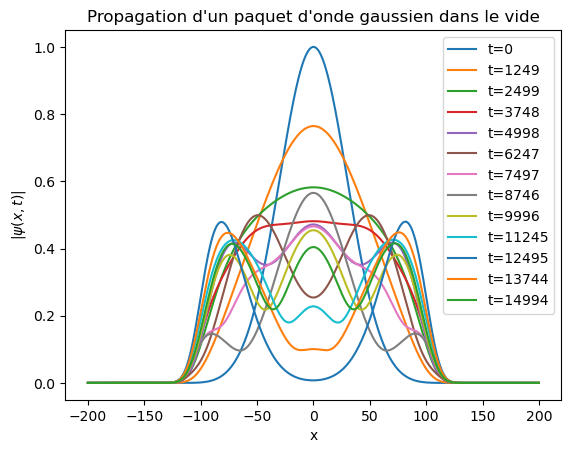

In [4]:
## Etalement d'un paquet d'onde gaussien sans potentiel ni laser
"""

Procédure:
    1. Définir les grilles spatiales et temporelles.
    2. Initialiser le solveur de Crank-Nicolson avec les paramètres de la grille.
    3. Définir la fonction d'onde initiale en utilisant une gaussienne.
    4. Résoudre l'équation de Schrödinger dépendant du temps en utilisant la méthode de Crank-Nicolson.
    5. Tracer la norme de la fonction d'onde à des temps spécifiés.
"""

def gaussian(x, x0, sigma, U_0):
    return U_0 * np.exp(-(x-x0)**2/(2*sigma**2))

def abs_cos18_potential(x, l, alpha=1):
    """
    Calculate the absorbing potential.
    Parameters:
    x (float array-like): The input value(s) for which the potential is calculated.
    l (float): coordinate limit of the grid.
    alpha (float, optional): Absorbing factor for the potential. Default is 0.1.
    Returns:
    complex array-like: The calculated potential as a complex number.
    """
    return -1j * alpha * (1 - np.power(np.abs(np.cos(np.pi * x/l)), 1/8))

# Those will not change
x_min, x_max, nx = -200, 200., 4096
t_min, t_max, nt = 0, 15000., 20000

# Construct the general Crank-Nicolson solver
crank = CrankNicolson()
crank.set_grid(x_min, x_max, nx, t_min, t_max, nt)
X = crank.x_pts


"""Ici on s'intéresse à la propagation d'un paquet d'onde gaussien sans potentiel ni laser. 
   On initialise la fonction d'onde avec une gaussienne centrée en x=0, avec une largeur de 30 et une amplitude de 1. 
   On résout ensuite l'équation de Schrödinger dépendant du temps en utilisant la méthode de Crank-Nicolson. 
   On trace la norme de la fonction d'onde à des temps spécifiés.
"""

def f(psi, t):
    return 0

crank.set_parameters(f)
psi_init = gaussian(crank.x_pts, 0, 30, 1)

crank.solve(psi_init, sparse=True)
times_to_plot = np.arange(0,nt-1, nt//12)
for t in times_to_plot:
    plt.plot(X, np.abs(crank.psi_matrix[t,:]), label=f't={int(t_min+t*crank.delta_t)}')
plt.xlabel('x')
plt.ylabel('$|\psi(x,t)|$')
plt.title("Propagation d'un paquet d'onde gaussien dans le vide")
plt.legend()
plt.show()

100%|██████████| 80000/80000 [00:39<00:00, 2013.03it/s]


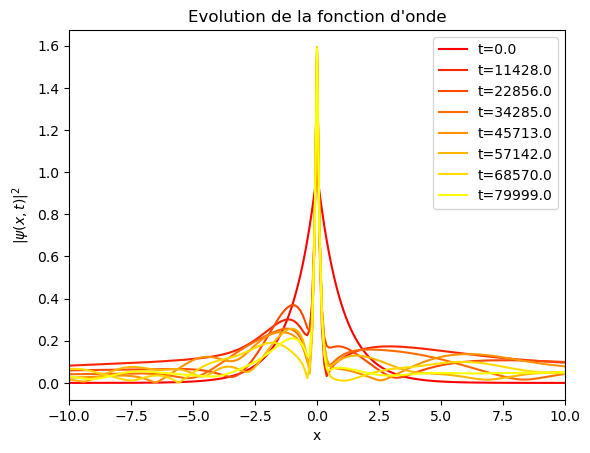

In [5]:
## Test: utilisation du solveur du fichier Solve.py et affichage de l'évolution de la fonction d'onde pour 8 valeurs sur l'intervalle de temps

# Rentrer les données de grille
x_min, nx, t_min, nt = -200, 4096, -20, 80000
wavefunction, x, t, A = psi([x_min, nx, t_min, nt], test=True)

T = np.linspace(0, nt-1, 8)
colors = cm.autumn(np.linspace(0, 1, len(T)))
for t, color in zip(T, colors):
    plt.plot(x, abs(wavefunction[int(t)]), label=f't={int(t):.1f}', color=color)
plt.xlim(-10, 10)
plt.legend()
plt.title("Evolution de la fonction d'onde")
plt.xlabel('x')
plt.ylabel('$|\psi(x,t)|^2$')
plt.show()
## ABS
